In [1]:
import sys
import os
import time
import torch
if hasattr(sys, 'frozen'):
    os.environ['PATH'] = sys._MEIPASS + ";" + os.environ['PATH']
from image_widget import ImageWidget
from common_utils import get_api_from_model
import threading
import qdarkstyle
import json
try:
    import queue
except ImportError:
    import Queue as queue
print(torch.cuda.is_available())

True


In [2]:
import importlib
def del_all_model_zoo_modules():
    alg_names = []
    for dir in os.listdir('./model_zoo'):
        if os.path.isdir(os.path.join('./model_zoo',dir)):
            alg_names.append(str(dir))

    # del path in sys.path
    del_p = []
    for p in sys.path:
        for alg_name in alg_names:
            if alg_name in p:
                del_p.append(p)
                break
    for p in del_p:
        sys.path.remove(p)

    # del modeules
    old_alg_names = []
    all_keys = sys.modules.keys()
    time.sleep(0.2)
    for alg_name in all_keys:
        if 'from' in str(sys.modules[alg_name]) and \
            'model_zoo' in str(sys.modules[alg_name]) and \
            'YoloAll' in str(sys.modules[alg_name]):
            old_alg_names.append(alg_name)
        if 'namespace' in str(sys.modules[alg_name]) and hasattr(sys.modules[alg_name], '__path__'):
            module_path = str(sys.modules[alg_name].__path__)
            if 'model_zoo' in module_path and \
               'YoloAll' in module_path:
               old_alg_names.append(alg_name)
            
    for alg_name in old_alg_names:
        del sys.modules[alg_name] 


def add_one_model_path(alg_name):
    sub_dir = os.path.join(alg_name)
    sys.path.append(sub_dir)

def get_api_from_model(alg_name):
    api = None
    del_all_model_zoo_modules()
    add_one_model_path(alg_name)
    
    try:
        api = importlib.import_module(alg_name)
        print('create api from', alg_name, 'success')
    except ImportError as e:
        print('create api from', alg_name, 'failed')
        print('error:', str(e))   
        api = None
        
    return api

In [24]:
path='model_zoo/YoloV3/alg'
alg_name=path.replace('/','.')
api = importlib.import_module(alg_name)
alg = api.Alg()
alg.load_cfg()
alg.create_model('yolov3_tiny', 'cuda')
alg.device

/mnt/c/Users/a7771/Desktop/YoloAll-2.0.1/model_zoo/YoloV3/cfg.yaml
/mnt/c/Users/a7771/Desktop/YoloAll-2.0.1/model_zoo/YoloV3/cfg.yaml


'cuda'

In [25]:
import cv2
img = cv2.imread('test.jpg')
#img=cv2.imread('4.jpg')
ret=alg.inference(img)
outname='out.mp4'

In [15]:
COCO_CLASSES = (
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
)

In [ ]:
def detection_object():
    DETECT_LEN_MIN = 1
    is_detect = []
    lst=[]
    x1,y1,x2,y2 yield 'new',len(lst),lst
    while (True):
        tmp=[x1,y1,x2,y2]
        tmp.append(tmp)
        is_detect.append(0 if x1+x2+y1+y2==0 else 1)
        if len(lst)< DETECT_LEN_MIN:
            x1,y1,x2,y2 yield 'add',len(lst),lst
        else:
            del lst[0] is_detect[0]
            x1,y1,x2,y2 yield 'replace',len(lst),lst
    

In [23]:
import cv2
import numpy as np
video_FourCC = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
cap=cv2.VideoCapture('B1_Cam1_1.mp4')
f=open('location','w')
def avg(a,b):
    return (a+b)/2
ready , frame =cap.read()
frame=frame[0:1080,400:1520,:]
width,  height=frame.shape[1], frame.shape[0]
out = cv2.VideoWriter(outname, fourcc, 15.0, (width,  height))
detection=detection_object()
detection.next()
while (ready):
    ret=alg.inference(frame)
    frames=ret['result']
    valid_pred=alg.valid_pred
    boxes = valid_pred[:,0:4]
    boxes = boxes.numpy()
    scores = valid_pred[:, 4]
    scores = scores.numpy()
    guess=valid_pred[:,5]
    for i,j in enumerate(guess): 
        if j!=0:
            boxes=np.delete(boxes,i,axis=0)
            scores=np.delete(scores,i,axis=0)
    ###########
    f.write(str(boxes)+','+str(scores)+'\n')
    cv2.imshow('frame',frames)
    out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    ready , frame =cap.read()
    if ready:
        frame=frame[0:1080,400:1520,:]
f.close()
out.release()
cv2.destroyAllWindows()

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [26]:
valid_pred=alg.valid_pred
boxes = valid_pred[:,0:4]
from common_utils import vis
import matplotlib.pyplot as plt
img_array=img
cls = valid_pred[:, 5]
scores = valid_pred[:, 4]
vis(img_array, boxes, scores, cls, conf=0.0)
map_result = {'type':'img'}
map_result['result'] = img_array


In [28]:
boxes


tensor([[151.1217,  36.8578, 330.4805, 239.3580]])

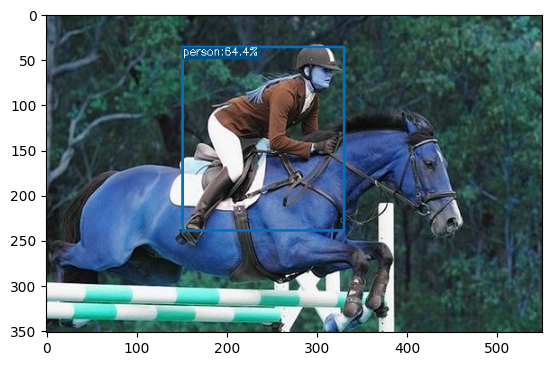

In [27]:
import matplotlib.pyplot as plt
plt.imshow(ret['result'])

In [4]:
a=[-1.4712,-0.73561,-0.36781,-0.1839,1.3618,1.491,-0.1619,0.010882,-0.022039,0.037758,-0.059629,-0.012593,0.057069,0.021796,-0.079172,0.07654,0.0083906,0.052962,0.078142,-0.06248,0.14278,-0.030219,-0.11347,0.28897,-0.029059,0.031352,0.097335,-0.058142,0.078739,-0.053578,0.076663,-0.027058,0.040533,-0.050662,0.0020356,-1.0074,0.48416,0.56294,-1.6958,0.90962,0.91519,0.0089953,0.021319,-1.1775,-0.012163,0.047574,0.042567,0.021267,1.217,-0.067659,-0.5881,-0.53334,-0.025609,0.0065138,0.0037017,-0.0019415,0.00071774,-1.2644,-0.62317,-0.31159,-0.15579,-0.077897,-0.038948,-0.019474,-0.0097371,-0.0048685,1.2327,1.2459,-0.0060704,0.0029044,-1.2462,0.6072,0.6162,0.017129,-1.2386,-0.61805,-0.30903,-0.15451,1.2008,1.2074,0.010026,1.3451,-0.13354,-0.1302,0.082337,0.076621,0.0014156,0.3051,-0.071308,0.41078,0.13573,-0.010148,0.088982,0.065948,0.076824,0.085331,0.075857,0.01216,0.081213,0.1662,0.31493,0.27543,0.15762,0.30475,0.25051,0.17722,0.15549,0.095065,0.091467,0.10305,0.13598,0.12677,0.18022,0.20939,0.20246,0.14801,0.10407,0.087335,0.12329,0.32184,0]

In [6]:
sum(a)

5.8595032400000004